# A005316

## Load

In [3]:
import matplotlib.pyplot as pyplot
import numpy
import pandas

_columns: list[str] = ['oeisID','n','boundary','buckets','arcCodes','arcCodeBitWidth','crossingsBitWidth']

df: pandas.DataFrame = pandas.read_csv('nBoundaryArc.csv', engine='pyarrow')
df.columns = _columns

## Add columns

In [4]:
df['nLess_boundary'] = df['n'] - df['boundary']
df['odd_boundary'] = df['boundary'] & 1
df['odd_n'] = df['n'] & 1
df['odd_nLess_boundary'] = df['nLess_boundary'] & 1

df.loc[df['oeisID'] == 'A000682', 'initialArcCodes'] = (df['n'] // 2) + 2
df.loc[df['oeisID'] == 'A005316', 'initialArcCodes'] = 1

df.loc[df['oeisID'] == 'A000682', 'initialArcCodesBitWidthMean'] = 4 + df['n'] % 2 + df['n']
df.loc[df['oeisID'] == 'A005316', 'initialArcCodesBitWidthMean'] = 4 - df['n'] % 2 + 1

df.loc[df['oeisID'] == 'A000682', 'initialArcCodesBitPopulationMean'] = 4 + df['n'] % 2 + df['n']
df.loc[df['oeisID'] == 'A005316', 'initialArcCodesBitPopulationMean'] = 4 + df['n'] % 2 - 1

df['initialArcCodesBitWidthTotal'] = df['initialArcCodes'] * df['initialArcCodesBitWidthMean']
df['initialArcCodesBitPopulationTotal'] = df['initialArcCodes'] * df['initialArcCodesBitPopulationMean']

In [5]:
dfA = df[(df['oeisID'] == 'A005316') & (df['odd_n'])]
dfB = df[(df['oeisID'] == 'A005316') & (~df['odd_n'])]

## Observations

In [ ]:
from mapFolding.reference.A005316facts import (
	bucketsIf_boundary_EVEN_by_nLess_boundary, bucketsIf_boundary_ODD_by_nLess_boundary)
from pprint import pprint

pprint(bucketsIf_boundary_ODD_by_nLess_boundary)
pprint(bucketsIf_boundary_EVEN_by_nLess_boundary)

### Initial conditions
A005316, closed meanders, always starts with 1 curveLocations. A000682, in contrast, always starts with 2 *or more* curveLocations: `curveLocations = (n // 2) + 2`. This difference makes it easier to analyze A005316 than A000682.

Furthermore, there are only 2 initial values of the 1 curveLocations. If n is odd, curveLocations = 15. If n is even, curveLocations = 22. This simplicity is an advantage when analyzing A005316.

### Total non-unique buckets is a function of n and boundary

If we compare the total number of non-unique buckets (bucketsTotal) at the same boundary across all values of n we can compute, we see three general trends. For a given boundary, as (n - boundary) increases:
1. bucketsTotal increases through a specific series of values.
2. At roughly boundary = n/2, bucketsTotal increases at an ever decreasing rate.
3. At roughly boundary = 2n, bucketsTotal stops increasing.

### More facts
- For example, for n >= 4 and boundary=1, bucketsTotal=3. Always. (The maximums also apply to A000682: in this case, for n >= 5 and boundary=1, bucketsTotal=3.)
- From n-boundary>=1 to boundary<=(n+1)//2, the value of buckets has two series: for odd and even values of boundary. (Hopefully, the Python cell above has the two series.)
- In each series, it seems easier to describe the growth by dividing the series into odd and even values of n-boundary.
- If boundary is odd, bucketsTotal is maxed out at (boundary*2+2 <= n-boundary)
- If boundary is even, bucketsTotal is maxed out at (boundary*2+1 <= n-boundary)
- or boundary ≤ (n - 1 - (boundary % 2)) // 3

## Visualize

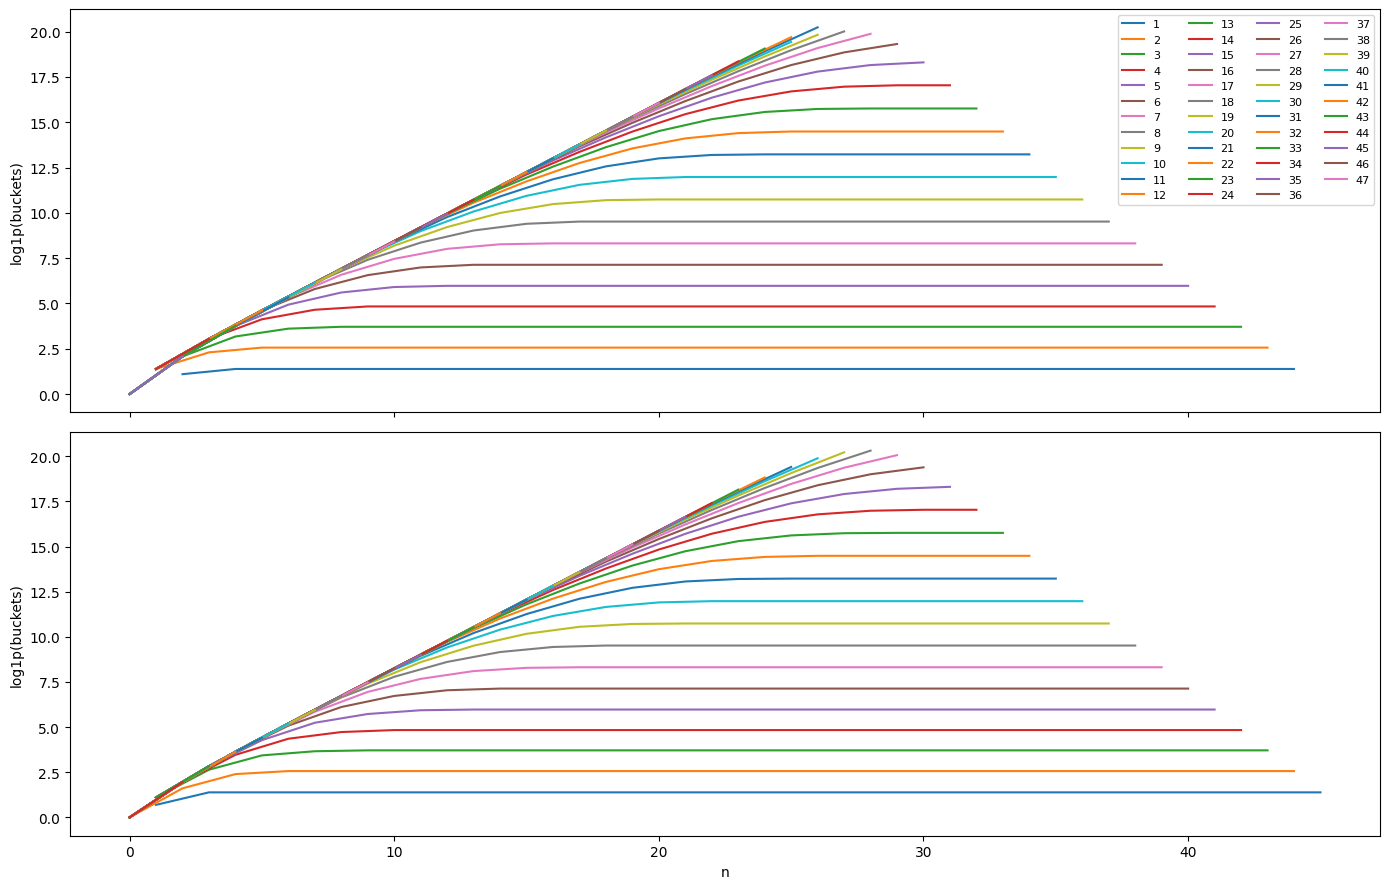

In [6]:
# pyright: basic

# fig, axes = pyplot.subplots(1, 1, figsize=(10, 8), sharex=True)
# for groupByValue, dataframeGroupBy in df.groupby('k'):
#     axes.plot(dataframeGroupBy['nLess_k'], numpy.log1p(dataframeGroupBy['buckets']), label=f"k={groupByValue}")
# axes.set_ylabel('log1p(buckets)')
# axes.set_xlabel('n')
# axes.legend(ncol=4, fontsize=8)
# pyplot.tight_layout()
# pyplot.show()
# # pyright: basic

fig, axes = pyplot.subplots(2, 1, figsize=(14, 9), sharex=True)
for groupByValue, dataframeGroupBy in dfA.groupby('boundary'):
    axes[0].plot(dataframeGroupBy['nLess_boundary'], numpy.log1p(dataframeGroupBy['buckets']), label=f"{groupByValue}")
for groupByValue, dataframeGroupBy in dfB.groupby('boundary'):
    axes[1].plot(dataframeGroupBy['nLess_boundary'], numpy.log1p(dataframeGroupBy['buckets']), label=f"{groupByValue}")
axes[0].set_ylabel('log1p(buckets)')
axes[1].set_ylabel('log1p(buckets)')
axes[1].set_xlabel('n')
axes[0].legend(ncol=4, fontsize=8)
pyplot.tight_layout()
pyplot.show()

## Pivot the data

In [ ]:
# # Pivot the data to create new columns for each value of 'k'
# # Flatten the MultiIndex columns and append "_kX" to column names
# # Reset the index to make 'nLess_k' a column and sort by 'nLess_k'
# def pivotOn_nLess_k(dataframeTarget: pandas.DataFrame) -> pandas.DataFrame:
# 	pivoted = dataframeTarget.pivot(index='nLess_k', columns='k', values=['n', 'buckets'])
# 	pivoted.columns = [f"{col[0]}_k{col[1]}" for col in pivoted.columns]
# 	pivoted = pivoted.reset_index().sort_values(by='nLess_k', ascending=True)
# 	pivoted = pivoted.set_index('nLess_k').reset_index()
# 	return pivoted
# df = pivotOn_nLess_k(df)
# df_even = pivotOn_nLess_k(df_even)
# df_odd = pivotOn_nLess_k(df_odd)

In [ ]:
bucketsTotalMaximumBy_boundary: dict[int, int] = {1:3, 2:12, 3:40, 4:125, 5:392, 6:1254, 7:4087, 8:13623, 9:46181, 10:159137, 11:555469, 12:1961369, 13:6991893, 14:25134208}

# nLess_boundary: int = state.n - state.boundary
# kIsOdd: bool = bool(state.boundary & 1)
# nLess_boundaryIsOdd: bool = bool(nLess_boundary & 1)
# kIsEven: bool = not kIsOdd

# bucketsTotalAtMaximum: bool = state.boundary <= ((state.n - 1 - (state.boundary % 2)) // 3)
# bucketsTotalGrowsExponentially: bool = state.boundary > nLess_boundary
# bucketsTotalGrowsLogarithmically: bool = state.boundary > ((state.n - (state.n % 3)) // 3)